In [1]:
import tensorflow
import keras
import numpy as np
import pickle
import cv2
import matplotlib.pyplot as plt
import math

Using TensorFlow backend.


In [2]:
from keras.layers import Conv2D, MaxPooling2D, Activation, UpSampling2D
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras import optimizers
from keras.callbacks import TensorBoard
from keras import backend as K
from keras import Input

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
class Parameters():
    def __init__(self, img_shape, optimiser, batch_size=128, number_classes=10, epochs=50, data_augmentation=False):
        self.batch_size = batch_size
        self.number_classes = number_classes
        self.epochs = epochs
        self.data_augmentation = data_augmentation
        self.img_shape = img_shape
        self.optimiser = optimiser

In [5]:
class Model():
    def __init__(self, params):
        self.params = params
        self.model = Sequential()
        
        self.encoder = Sequential()
        self.encoder.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=self.params.img_shape))
        self.encoder.add(MaxPooling2D(pool_size=(2,2), padding='same'))
        self.encoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
        self.encoder.add(MaxPooling2D(pool_size=(2,2), padding='same'))
        self.encoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
        self.encoder.add(MaxPooling2D(pool_size=(2,2), padding='same'))
        
        self.decoder = Sequential()
        self.decoder.add(Conv2D(8, (3, 3), activation='relu', padding='same', input_shape=self.encoder.layers[-1].output_shape[1:]))
        self.decoder.add(UpSampling2D((2,2)))
        self.decoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
        self.decoder.add(UpSampling2D((2,2)))
        self.decoder.add(Conv2D(16, (3, 3), activation='relu'))
        self.decoder.add(UpSampling2D((2,2)))
        self.decoder.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same')) # activation can be added as parameter as well
        self.model.add(self.encoder)
        self.model.add(self.decoder)
        
    def compile(self, loss="binary_crossentropy", metrics=['accuracy']):
        self.model.compile(loss=loss, optimizer=self.params.optimiser)
        
    def fit(self, x_train, y_train, validation_data, shuffle=True, callbacks=[TensorBoard(log_dir='conv_autoencoder')], verbose=2):
        self.model.fit(x_train, y_train, epochs=self.params.epochs, batch_size=self.params.batch_size, 
                       shuffle=shuffle, validation_data=validation_data, callbacks=callbacks, verbose=verbose)
    

In [6]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))    
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [7]:
params = Parameters(img_shape=x_train.shape[1:], epochs=30, 
                    optimiser=keras.optimizers.Adadelta(lr=0.5, rho=0.95, epsilon=None, decay=0.0))
m = Model(params)
m.compile()
m.fit(x_train, x_train, (x_test, x_test), verbose=1) # as test is the same image
# m.model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 79s 1ms/step - loss: 0.2414 - val_loss: 0.1834
Epoch 2/30
60000/60000 [==============================] - 73s 1ms/step - loss: 0.1685 - val_loss: 0.1539
Epoch 3/30
60000/60000 [==============================] - 73s 1ms/step - loss: 0.1522 - val_loss: 0.1434
Epoch 4/30
60000/60000 [==============================] - 73s 1ms/step - loss: 0.1430 - val_loss: 0.1380
Epoch 5/30
60000/60000 [==============================] - 73s 1ms/step - loss: 0.1370 - val_loss: 0.1343
Epoch 6/30
60000/60000 [==============================] - 73s 1ms/step - loss: 0.1317 - val_loss: 0.1272
Epoch 7/30
60000/60000 [==============================] - 73s 1ms/step - loss: 0.1273 - val_loss: 0.1262
Epoch 8/30
60000/60000 [==============================] - 73s 1ms/step - loss: 0.1241 - val_los

In [8]:
pickle_write = open("conv_autoenc_model.pickle","wb")
pickle.dump([m.encoder.get_weights(), m.decoder.get_weights()], pickle_write)
pickle_write.close()

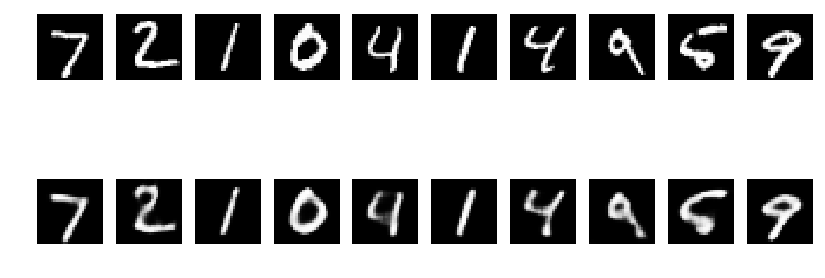

In [9]:
n = 10
decoded_imgs = m.model.predict(x_test)
plt.figure(figsize=(10, 4), dpi=100)
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.set_axis_off()

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.set_axis_off()

plt.show()

In [10]:
def convolve(x, y, mat, k):
    val = 0
    center_x = int((k.shape[0]-1)/2); center_y = int((k.shape[1]-1)/2)
    for i in range(-1*center_x, center_x+1):
        for j in range(-1*center_y, center_y+1):
            idx_x = x+i
            idx_y = y+j
            if idx_x>=0 and idx_y>=0 and idx_x<mat.shape[0] and idx_y<mat.shape[1]:
                val+=mat[idx_x][idx_y]*k[i+center_x][j+center_y]
    return val

In [11]:
def my_conv2d(input_matrix, kernel_weights, padding="not same"):
    s = kernel_weights[0].shape
    output_channels = s[3]
    input_channels = s[2]
    output=[]
    img_rows = input_matrix.shape[0]
    img_cols = input_matrix.shape[1]
    row_pad_cut = int((s[0]-1)/2)  #number of rows to be cut if padding is not same
    col_pad_cut = int((s[1]-1)/2)
    
    if padding == "same":
        output=np.zeros((img_rows, img_cols, output_channels))
    else:
        output=np.zeros((img_rows-2*row_pad_cut, img_cols-2*col_pad_cut, output_channels))
    
    for out_chan in range(output_channels):
        for in_chan in range(input_channels):
            mat = input_matrix[:,:,in_chan] 
            k = kernel_weights[0][:,:,in_chan, out_chan]
            for x in range(img_rows):
                for y in range(img_cols):
                    if padding == "same":
                        output[x,y,out_chan] += convolve(x, y, mat, k)
                    elif (x>=row_pad_cut and y>=col_pad_cut 
                             and x<(img_rows-row_pad_cut) and y<(img_cols-col_pad_cut)):
                        output[x-row_pad_cut, y-row_pad_cut,out_chan] += convolve(x, y, mat, k)
    
    return output
    

In [12]:
input_matrix = x_test[0]
z = my_conv2d(input_matrix, m.encoder.layers[0].get_weights(), "same")
z.shape

(28, 28, 16)

In [13]:
m.decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 4, 4, 8)           584       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 8)           584       
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 16)        1168      
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 1)         145       
Total para

In [14]:
def my_maxpool(shape, matrix):
    rows=int(math.ceil(matrix.shape[0]/shape[0]))
    cols=int(math.ceil(matrix.shape[1]/shape[1]))
    output=np.zeros((rows, cols, matrix.shape[2]))
    
    for out_chan in range(matrix.shape[2]):
        for x in range(0, matrix.shape[0], shape[0]):
            for y in range(0, matrix.shape[1], shape[1]):
                mx = -1
                for i in range(0,shape[0]):
                    for j in range(0, shape[1]):
                        if (x+i)<matrix.shape[0] and (y+j)<matrix.shape[1]:
                            if matrix[x+i][y+j][out_chan]>mx:
                                mx=matrix[x+i][y+j][out_chan]
                output[int(x/shape[0])][int(y/shape[1])][out_chan]=mx
    
    return output

In [15]:
x = [[1,2,3,4,5,6,7],[1,2,3,4,5,6,7],[1,2,3,4,5,6,7],[1,2,3,4,5,6,7],[1,2,3,4,5,6,7],[1,2,3,4,5,6,7],[1,2,3,4,5,6,7]]
x=np.array(x)
x=x.reshape(7,7,1)
y=my_maxpool((2,2), x)
y

array([[[2.],
        [4.],
        [6.],
        [7.]],

       [[2.],
        [4.],
        [6.],
        [7.]],

       [[2.],
        [4.],
        [6.],
        [7.]],

       [[2.],
        [4.],
        [6.],
        [7.]]])

In [16]:
def my_upsample(shape, matrix):
    rows=matrix.shape[0]*shape[0]
    cols=matrix.shape[1]*shape[1]
    output=np.zeros((rows, cols, matrix.shape[2]))
    
    for out_chan in range(matrix.shape[2]):
        for x in range(matrix.shape[0]):
            for y in range(matrix.shape[1]):
                for i in range(shape[0]):
                    for j in range(shape[1]):
                        output[x*shape[0]+i][y*shape[0]+j][out_chan]=matrix[x][y][out_chan]
    
    return output

In [17]:
x = [[1,2],[5,6]]
x=np.array(x)
x=x.reshape(1,1,4)
y=my_upsample((2,2), x)
y

array([[[1., 2., 5., 6.],
        [1., 2., 5., 6.]],

       [[1., 2., 5., 6.],
        [1., 2., 5., 6.]]])

In [18]:
input_matrix = x_test[4]
z = my_conv2d(input_matrix, m.encoder.layers[0].get_weights(), "same")
z = np.maximum(0,z)
z = my_maxpool((2,2),z)
z = my_conv2d(z, m.encoder.layers[2].get_weights(), "same")
z = np.maximum(0,z)
z = my_maxpool((2,2),z)
z = my_conv2d(z, m.encoder.layers[4].get_weights(), "same")
z = np.maximum(0,z)
z = my_maxpool((2,2),z)
z.shape

(4, 4, 8)

In [19]:
z = my_conv2d(z, m.decoder.layers[0].get_weights(), "same")
z = np.maximum(0,z)
z = my_upsample((2,2), z)
z = my_conv2d(z, m.decoder.layers[2].get_weights(), "same")
z = np.maximum(0,z)
z = my_upsample((2,2), z)
z = my_conv2d(z, m.decoder.layers[4].get_weights())
z = np.maximum(0,z)
z = my_upsample((2,2), z)
z = my_conv2d(z, m.decoder.layers[6].get_weights(), "same")
z.shape

(28, 28, 1)

In [20]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum() 

In [21]:
z = softmax(z)
z.shape

(28, 28, 1)

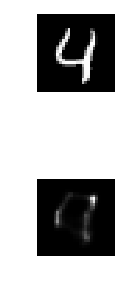

In [22]:
n = 1
decoded_imgs = m.model.predict(x_test)
plt.figure(figsize=(1, 4), dpi=100)
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(input_matrix.reshape(28, 28))
    plt.gray()
    ax.set_axis_off()

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(z.reshape(28, 28))
    plt.gray()
    ax.set_axis_off()

plt.show()

(28, 28, 1)
Tensor("strided_slice_53:0", shape=(28, 28, 1), dtype=float32)
(28, 28, 1)


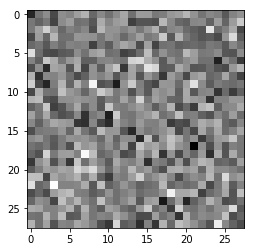

In [68]:
import tensorflow as tf
x = tf.random.normal(shape=[10,28,28,1], dtype=tf.float32)
x_ = x[0,:,:,:]
print(x_.shape)
# X = tf.reshape(x_, [28,28])
print(x_)
t = tf.Session().run(x_)
print(t.shape)
t_ = t.reshape(28,28)
plt.imshow(t_)

In [69]:
tf.__version__

'1.13.1'